# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [3]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [4]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

/home/boris/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/boris/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

[1591 5608] [0 1 2]


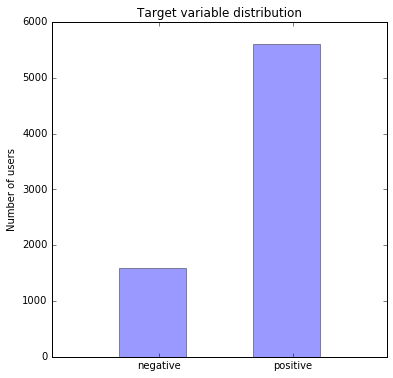

In [5]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])
print counts,bins
# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [6]:
CONSUMER_KEY = "5ZvkvirVIgqrSSV4iDQbEcGtu" # "your_key" 
CONSUMER_SECRET = "Pv2Ei2akukdHUHRsa7Zd96qHs2gRskXMN2uHLaHwe3Tzt2tQMI" # "your_secret"

ACCESS_TOKEN_KEY = "780509761984921601-IoQnm1ErbJcwZZrBS9aHJeiyr2m5gFc" # "your_token_key"
ACCESS_TOKEN_SECRET = "r31dpSxgJPFdyfrja89Ey58rfT5GZSQO7xApo21FCz6x2" #"your_token_secret" 

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [7]:
import requests
import json

In [8]:
GEO_USER_NAME = "yakimoris"
global coordinates 
coordinates = {}
def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    if location not in coordinates:
        geo_url = u'http://api.geonames.org/searchJSON?q="{0}"&maxRows=1&username={1}'.format(location,GEO_USER_NAME)
        r = requests.get(geo_url)
        data = json.loads(r.text)
        try:
            latitude = float(data["geonames"][0]['lat'])
            longtitude = float(data["geonames"][0]['lng'])
            countryName = data["geonames"][0][u'countryName']
        except:
            latitude = None
            longtitude = None
            countryName = None
            
        coordinates[location] = (latitude,longtitude,countryName)
    latitude, longtitude, countryName = coordinates[location]
    # your code here
    return (latitude,longtitude,countryName) #latitude, longtitude, Country name

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [9]:
def get_next_hundred_slice(l):
    last = 0
    while(last<len(l)):
        first,last = last,last+100
        if last>=len(l):
            last = len(l)
        yield l[first:last]

In [10]:
def set_twitter_record_with_NaN(uid):
    record = {
        "statuses_count":None,
        "uid": uid, 
        "friends_count": None,
        "lat":None,
        "favourites_count": None,
        "description": None,
        "verified": None,
        "screen_name": None,
        "country": None, 
        "created_at": None,
        "lon": None,
        "name": None,
        "followers_count": None,
        "location": None,
        "listed_count": None
        }
    return record

В следующей ячейке загружаются данные пользователей твиттера из уже скачанной базы данных, 
если же база данных 'full.csv' отсутствует, или возникает любая другая ошибка, то данные загружаются из твиттера 

In [11]:
try:
    df_full = pd.read_csv('full.csv')
except:
    ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

    user_records = []
    tmp_file_name = 'tmp_user_records'
    if os.path.exists(tmp_file_name):
        with open(tmp_file_name) as f:
            for line in f:
                try:
                    user_records.append(json.loads(line))
                except:
                    continue

    processed_users = set()
    for r in user_records:
        processed_users.add(r['uid'])

    def twitter_user_to_dataframe_record(user):
        dt = ts_parser(user.created_at)
        record = {
            "uid": user.id,
            "name": user.name,
            "screen_name": user.screen_name,        
            "created_at": dt.strftime("%Y-%m") if dt else dt,        
            "followers_count": user.followers_count,
            "friends_count": user.friends_count,
            "statuses_count": user.statuses_count,
            "favourites_count": user.favourites_count,
            "listed_count": user.listed_count,
            "verified": user.verified
        }

        if user.description is not None and user.description.strip() != "":
            record["description"] = user.description

        if user.location is not None and user.location.strip() != "":
            record["location"] = user.location
            record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)

        return record


    def get_user_records(df):
        # your code here
        # some_downloaded_user = get_user_from_api
        # also write user as json line in temporary file
        # return [twitter_user_to_dataframe_record(some_downloaded_user)]
        list_of_uids = df['uid'].tolist()
        user_recs = []
        with open(tmp_file_name, 'a') as f:
            for uid_slc in get_next_hundred_slice(list_of_uids):
                filtered_uid_slc = [x for x in uid_slc if x not in processed_users]
                if len(filtered_uid_slc) != 0:
                    try:
                        list_of_users = api.UsersLookup(user_id = filtered_uid_slc)
                        for user in list_of_users:
                            record = twitter_user_to_dataframe_record(user)
                            processed_users.add(record['uid'])
                            str_rec = json.dumps(record)
                            f.write(str_rec)
                            f.write('\n')
                            user_recs.append(record)
                    except:
                        pass
        return user_recs

    # Maximum number of user IDs returned by Twitter's user lookup

    user_records.append(get_user_records(df_users))


    print "Creating data frame from loaded data"
    df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
    print "Merging data frame with the training set"
    df_full = pd.merge(df_users, df_records, on="uid", how="left")
    print "Finished building data frame"

### Saving intermediate results

In [12]:
INTERMEDIATE_OUTPUT_FILEPATH = 'full.csv'
df_full.to_csv(INTERMEDIATE_OUTPUT_FILEPATH, index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

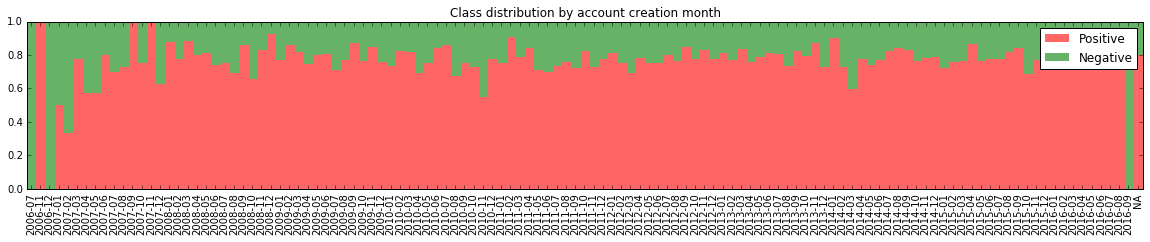

In [13]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    # your code here
    count_pos = grouped.apply(lambda x: x[x['cls'] == 1]['cls'].count()).tolist()
    count_neg = grouped.apply(lambda x: x[x['cls'] == 0]['cls'].count()).tolist()
    count_pos = np.array(count_pos)
    count_neg = np.array(count_neg)
    dts = [x[0] for x in grouped]
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

In [14]:
def sized_positions(lon_pos,lat_pos):
    """return positions latitude longtitude and size that's 
    proportional to number of occurrences (number of users of pos/neg type)"""
    try:
        lat_pos = lat_pos[~numpy.isnan(lat_pos)]
        lon_pos = lon_pos[~numpy.isnan(lon_pos)]
    except:
        pass
    
    positions = np.vstack((lon_pos,lat_pos)).T.tolist()
    positions = tuple(tuple(x) for x in positions)
    pos_dict = {}
    for x in positions:
        if x not in pos_dict:
            pos_dict[x] = 0
        pos_dict[x] += 1
        
    lat, lon, count = [],[],[]
    for pos,c in pos_dict.iteritems():
        lon.append(pos[0])
        lat.append(pos[1])
        count.append(c)
    count,lon,lat = zip(*sorted(zip(count,lon,lat),reverse = True))
    return np.array(lon),np.array(lat),count


In [15]:
def colored_sized_positions(lon_pos,lat_pos,lon_neg,lat_neg):
    """return arrays of longtitude, latitude list of colors in (R,G,B) where 0<=R,G,B<=1
    and size ~ sqrt(number of users in city)"""
    pos_ln,pos_lt ,pos_c = sized_positions(lon_pos,lat_pos)
    neg_ln, neg_lt, neg_c = sized_positions(lon_neg,lat_neg)

    pos_dict = {}
    for x in zip(pos_ln,pos_lt,pos_c):
        pos_dict[(x[0],x[1])] = [x[2],0,0.]
        
    for x in zip(neg_ln,neg_lt,neg_c):
        if (x[0],x[1]) not in pos_dict:
            pos_dict[(x[0],x[1])] = [0,0,0.]
        pos_dict[(x[0],x[1])][1] += x[2]
    
    s = []
    for key,value in pos_dict.iteritems():
        N = float(value[0]+value[1])
        s.append(np.sqrt(N))
        pos_dict[key] = [value[0]/N,value[1]/N,0.]
    lat, lon, color = [],[],[]
    
    for pos,c in pos_dict.iteritems():
        lon.append(pos[0])
        lat.append(pos[1])
        color.append(tuple(c))
    s,lon,lat,color = zip(*sorted(zip(s,lon,lat,color),reverse = True))
    return np.array(lon),np.array(lat),color, s


### Map

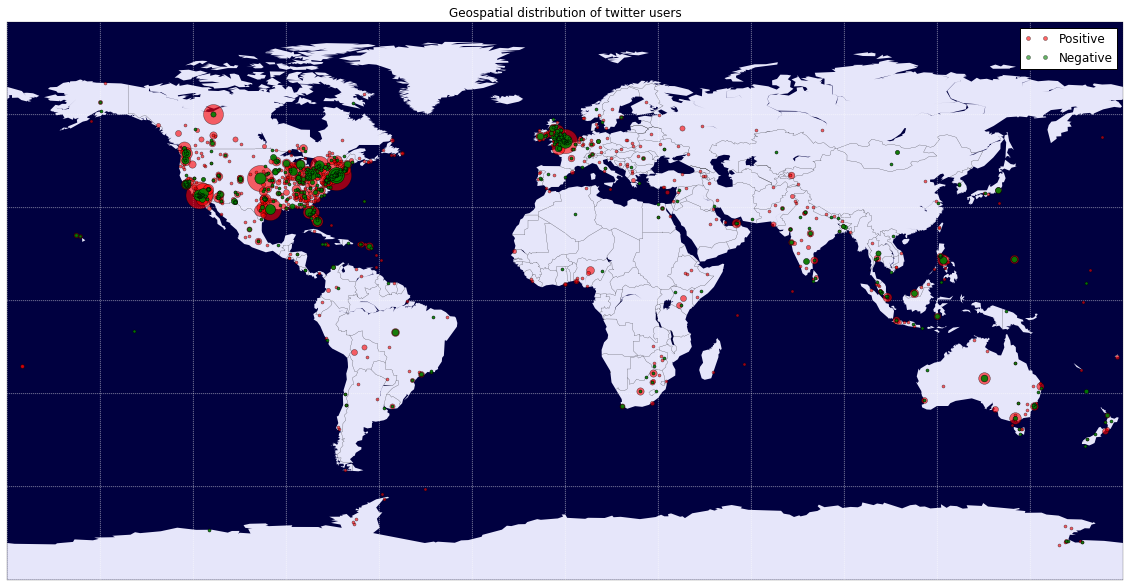

In [16]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    lat_pos = np.array(df_full['lat'][df_full['cls'] == 1].tolist())
    lon_pos = np.array(df_full['lon'][df_full['cls'] == 1].tolist())
    
    lon, lat,mar_size = sized_positions(lon_pos,lat_pos)
    for ln,lt,m_s in zip(lon,lat,mar_size):
        m.plot(ln,lt,'ro',alpha = 0.6,markersize = 3.*np.sqrt(m_s))
    ln, lt, m_s = lon[-1],lat[-1],mar_size[-1]
    m.plot(ln,lt,'ro',alpha = 0.6,markersize = 4, label ="Positive")
    lat_neg = np.array(df_full['lat'][df_full['cls'] == 0].tolist())
    lon_neg = np.array(df_full['lon'][df_full['cls'] == 0].tolist())
    lon, lat,mar_size = sized_positions(lon_neg,lat_neg)
    for ln,lt,m_s in zip(lon,lat,mar_size):
        m.plot(ln,lt,'go',alpha = 0.9,markersize = 3.*np.sqrt(m_s))
    ln, lt, m_s = lon[-1],lat[-1],mar_size[-1]
    m.plot(ln,lt,'go',alpha = 0.6,markersize = 4, label ="Negative")
    pl.legend()
    #m.plot(lon_neg,lat_neg,'go',markersize = 4)
    # your code here
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

### Creating interactive map 

In [ ]:
try:
    import mpld3
except ImportError:
    print "Oops,  I think you have to install mpld3"

In [ ]:
fig = pl.figure(figsize=(12,10))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    lat_pos = np.array(df_full['lat'][df_full['cls'] == 1].tolist())
    lon_pos = np.array(df_full['lon'][df_full['cls'] == 1].tolist())
    lon, lat, mar_size = sized_positions(lon_pos,lat_pos)
    
    for ln,lt,m_s in zip(lon,lat,mar_size):
        m.plot(ln,lt,'ro',alpha = 0.6, markersize = 3.*np.sqrt(m_s))
    ln, lt, m_s = lon[-1],lat[-1],mar_size[-1]
    m.plot(ln,lt,'ro',alpha = 0.6,markersize = 4, label ="Positive")
    
    lat_neg = np.array(df_full['lat'][df_full['cls'] == 0].tolist())
    lon_neg = np.array(df_full['lon'][df_full['cls'] == 0].tolist())
    lon, lat, mar_size = sized_positions(lon_neg,lat_neg)
    
    for ln,lt,m_s in zip(lon,lat,mar_size):
        m.plot(ln,lt,'go',alpha = 0.9, markersize = 3.*np.sqrt(m_s))
    ln, lt, m_s = lon[-1],lat[-1],mar_size[-1]
    m.plot(ln,lt,'go',alpha = 0.6,markersize = 4, label ="Negative")
    pl.legend()
    #m.plot(lon_neg,lat_neg,'go',markersize = 4)
    # your code here
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users, interactive map")
pl.legend()
mpld3.display(fig)

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На обоих изображениях сделаны следующие улучшения:
* Скорректирована прозрачность точек
* Размер точки теперь зависит от числа пользователей (отрицательных или положительных) в этом городе (при этом, очевидно, вместо нескольких точек для одного города отображается одна точка для положительных объектов и одна для отрицательных красным и зеленым цветами соответственно)
* было выбрано, что размер точки, характерзиуемый параметром markersize ~ $\sqrt{N}$, где N - количество положительных(или отрицательных) пользователей, так как это позволяет отобразить как "некрупные" так и "большие" города.
* Точки "рисуются" на карте в порядке убывания, таким образом крупные точки не перекрывают более мелкие, находящиеся рядом
* **Второе изображение** использует утилиту mpld3, которая позволяет рассматривать увеличенное изображение карты (для этого необходимо выбрать в нижнем левом углу окна изображения "лупу" и выбрать интересующий участок карты, однако карта при этом остаётся исходной точности, к сожалению) 
* Стоит также отметить, что было проверена гипотеза об отображении для каждого города лишь одной точки, показывающей в виде цвета соотношение положительных/отрицательных объектов выборки, что реализовано в функции colored_sized_positions, однако цветовая гамма от красного до зелёного плохо различима для данной выборки (по крайней мере, по мнению автора)  

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

In [ ]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

matplotlib.style.use('ggplot')

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    
    #calculating statistics
    
    nmax,pmax = users_wth_neg_class['followers_count'].max(), users_wth_pos_class['followers_count'].max()
        
    nmin,pmin = users_wth_neg_class['followers_count'].min(),users_wth_pos_class['followers_count'].min()
   
    nmean, pmean = users_wth_neg_class['followers_count'].mean(),users_wth_pos_class['followers_count'].mean()
    
    nstd, pstd = users_wth_neg_class['followers_count'].std(),users_wth_pos_class['followers_count'].std()
    
    nmed, pmed = users_wth_neg_class['followers_count'].median(),users_wth_pos_class['followers_count'].median()
    #plotting histogram
    pl.figure(figsize = (10,8))
    pl.grid()
    binwidth = 3000
    label_temp = "distribution of followers count by {} class users"
    users_wth_pos_class['followers_count'].plot.hist(label = label_temp.format('positive'), 
                                                     color = 'blue', bins = 30,
                                                     alpha = 0.45,histtype = 'bar')
    users_wth_neg_class['followers_count'].plot.hist(label = label_temp.format('negative'),
                                                     color = 'green',bins= 30,
                                                     alpha = 0.45,histtype = 'bar')

    pl.legend()
    pl.yscale('log') #semilogy scale
    pl.xlabel('Value')
    pl.title('Followers count')
    

    #printing some stats
    print "Maximum"
    print 'max neg = ',nmax
    print 'max pos = ',pmax
    print '\n Minimum'
    print 'min neg = ',nmin
    print 'min pos = ',pmin
    print '\n Mean'
    print 'mean +/-std neg = ', nmean ,'+\-', nstd
    print 'mean +/-std pos = ', pmean ,'+\-', pstd
    print '\n Median'
    print 'meadian neg = ', nmed
    print 'meadian pos = ', pmed
        #Calculate min max and median. Plot histogram
        #Your code here
    return nmax,pmax,nmin,pmin,nmean,pmean,nmed,pmed

descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)

Ответы на вопросы: 
1. Среднее смещенно по отношению к медиане в обоих случаях, так как есть "выбросы" в выборке, т.е. пользователи с большим, по отношению к большинсту других пользователей, числом followers_count.
2. С незначительным (в среднем) преимуществом популярнее пользователи отрицательного класса, т.к. медианы для данных классов практически равны, а среднее для отрицательного класса приблизительно в полтора раза больше. Так же, об этом говорит и величины стандартных отклонений для данных классов.


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [ ]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()